# Analyzing Metrics Results

Analyzing and drawing conclusions from metric results

In [1]:
from codegaze.datamodel import ExperimentConfig
from codegaze.experiment import Experiment
from codegaze import metrics, CodeBlockParser
from codegaze.datamodel import CodeBlock
import os 
from tqdm import tqdm
import pandas as pd 
import numpy as np
from codegaze.utils import load_json, save_json, get_dirs
import json

import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
base_data_path = "../experiments/data"

pass_at_max = "pass@20"
cor_method = "pearson"

def load_metrics(config: ExperimentConfig, metric:str):
    metric_path = f"{base_data_path}/{config.dataset}/{config.slug}/{config.model}/metrics/{metric}" 
    metrics = []
    for file in os.listdir(metric_path):
        if file.endswith(".json"):
            metrics.append(load_json(f"{metric_path}/{file}"))
    return pd.DataFrame(metrics)

def summarize_results(config: ExperimentConfig): 
    function_df = load_metrics(config, "function")
    block_df = load_metrics(config, "block")
    all_metrics = pd.merge(function_df, block_df, on="problem")
    return all_metrics

def plot_results(all_metrics, config: ExperimentConfig):
    plt.figure(figsize=(18,8))
    ax = sns.kdeplot(all_metrics["edit_distance"] , shade=True, color="blue", label="Edit Distance")
    ax = sns.kdeplot(all_metrics["ast_distance"] , shade=True, color="red", label="AST Distance")
    ax = sns.kdeplot(all_metrics["jw_distance"] , shade=True, color="green", label="Jaro-Winkler Distance")
    ax = sns.kdeplot(all_metrics["neural_distance"] , shade=True, color="orange", label="Neural Distance")
    ax = sns.kdeplot(all_metrics[pass_at_max] , shade=True, color="black", label=pass_at_max)
    plt.title(f"Distribution of Agg Metrics for Each Function in HumanEval | {config.slug}  | {config.model}")
    plt.legend();


    plt.figure(figsize=(18,8))
    sns.kdeplot(all_metrics["pass@1"] , shade=True, color="blue", label="Pass@1")
    sns.kdeplot(all_metrics[pass_at_max] , shade=True, color="black", label=pass_at_max)
    plt.title(f"Distribution of Agg Metrics for Each Function in HumanEval | {config.slug}  | {config.model}")
    plt.legend();

    plt.figure(figsize=(18,10))
    sns.set(font_scale=1.4)
    sub_df = all_metrics[["pass@1",pass_at_max,"edit_distance", "ast_distance","jw_distance","neural_distance"]]
    sns.heatmap(sub_df.corr(method=cor_method), annot = True,cmap= 'coolwarm', annot_kws={"size":18});
    plt.title(f"Correlation between Metrics  | {config.slug} | {config.model}", fontsize=20);

def process_results(config: ExperimentConfig) -> None: 
    all_metrics = summarize_results(config)
    # plot_results(all_metrics, config) 
    return all_metrics 


In [3]:
# use /dataset/metrics directory as source of truth for available results
# list datasets  list 
# list experiments 
# on experiment click ... construct config object and process metrics

datasets = os.listdir(f"{base_data_path}")
dataset = datasets[0]
experiments = os.listdir(f"{base_data_path}/{dataset}") 
experiment = experiments[0]
models = get_dirs(f"{base_data_path}/{dataset}/{experiment}")
 

exp = Experiment("completion_experiment", data_path=base_data_path)
holder = []
for model in models:
    config_path = f"{base_data_path}/{dataset}/{experiment}/config.json"
    config = load_json(config_path) 
    config = ExperimentConfig(**config) 
    config.model = model
    mean_metrics = exp.get_results(config, model) 
    
    mean_metrics["model"] = config.model 
    holder.append(mean_metrics)

In [4]:
models = exp.list_models(config.dataset, config.slug)

model_results = []
for model in models:
    metrics = exp.get_results(config, model)
    model_results.append({"model": model, "metrics": metrics})

In [18]:


def get_rankings(results):
    rankings = {}
    result = results[0]
    def sort_imp(result, target_metric):
     for metric_type in result["metrics"]:
        for metric in result["metrics"][metric_type].keys():
            combined_metric = ":".join([metric_type, metric])
            if combined_metric == target_metric:
                return result["metrics"][metric_type][metric]
    def sortModels(results, targetMetric): 
        results = sorted(results, key=lambda x: sort_imp(x, targetMetric), reverse=True)
        return results

    for metric_type in result["metrics"].keys():
        for metric in result["metrics"][metric_type].keys():
            combined_metric = ":".join([metric_type, metric])
            sorted_models = [x["model"] for x in sortModels(results, combined_metric)]
            sorted_models = "".join(sorted_models) 
            if (sorted_models not in rankings):
                rankings[sorted_models] = [combined_metric]
            else:
                rankings[sorted_models] = rankings[sorted_models] + [combined_metric]
    return rankings


In [19]:
get_rankings(model_results)

{'code-davinci-002davinci-codex-002-msftcode-davinci-001code-cushman-001': ['function:pass@1',
  'function:pass@10'],
 'davinci-codex-002-msftcode-davinci-002code-cushman-001code-davinci-001': ['function:cat_edit',
  'function:cat_ast'],
 'davinci-codex-002-msftcode-davinci-002code-davinci-001code-cushman-001': ['function:cat_jw',
  'cat:cat_edit',
  'cat:cat_ast',
  'cat:cat_jw',
  'cat:cat_neural'],
 'code-davinci-002davinci-codex-002-msftcode-cushman-001code-davinci-001': ['function:cat_neural']}

In [6]:
[x["model"] for x in sortModels(model_results, "function:pass@1")]

['code-davinci-002',
 'davinci-codex-002-msft',
 'code-davinci-001',
 'code-cushman-001']

In [12]:
holder

[{'function': {'pass@1': 0.3359756097560975,
   'pass@10': 0.3597560975609756,
   'cat_edit': 0.3743985853938567,
   'cat_ast': 0.43817678004724936,
   'cat_jw': 0.6534519577358201,
   'cat_neural': 0.8999618927880031},
  'cat': {'cat_edit': 0.7257506317598649,
   'cat_ast': 0.9092741641289842,
   'cat_jw': 0.8821447914734409,
   'cat_neural': 0.9592117510904732},
  'model': 'code-davinci-001'},
 {'function': {'pass@1': 0.31768292682926824,
   'pass@10': 0.3353658536585366,
   'cat_edit': 0.3785012322949706,
   'cat_ast': 0.4536006909369252,
   'cat_jw': 0.6523026417740212,
   'cat_neural': 0.9029921235107794},
  'cat': {'cat_edit': 0.7099751719056526,
   'cat_ast': 0.9040955638948526,
   'cat_jw': 0.874584259177419,
   'cat_neural': 0.9568441857525051},
  'model': 'code-cushman-001'},
 {'function': {'pass@1': 0.45304878048780484,
   'pass@10': 0.4634146341463415,
   'cat_edit': 0.42164847311120485,
   'cat_ast': 0.48689006726333545,
   'cat_jw': 0.6726042716441376,
   'cat_neural': 0.

In [11]:
df = pd.concat(holder, axis=0)
df.sort_values(by="pass@1", inplace=True)
df.insert(0, "model_name", df["model"])
df.drop(columns=["model"], inplace=True)
df

TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

In [3]:
from codegaze.datamodel import ExperimentConfig
conf = {'prompt_tokens': 1, 'n_completions': 120, 'lines_per_block': 10, 'model': 'davinci-codex-002-msft', 'slug': 'pt1_ml10_t0.8', 'model_type': 'openai', 'dataset': 'humaneval', 'parser_retry': True, 'temperature': 0.8}
config = ExperimentConfig(**conf)
config 

ExperimentConfig(prompt_tokens=1, n_completions=120, lines_per_block=10, model='davinci-codex-002-msft', slug='pt1_ml10_t0.8', model_type='openai', dataset='humaneval', parser_retry=True, temperature=0)

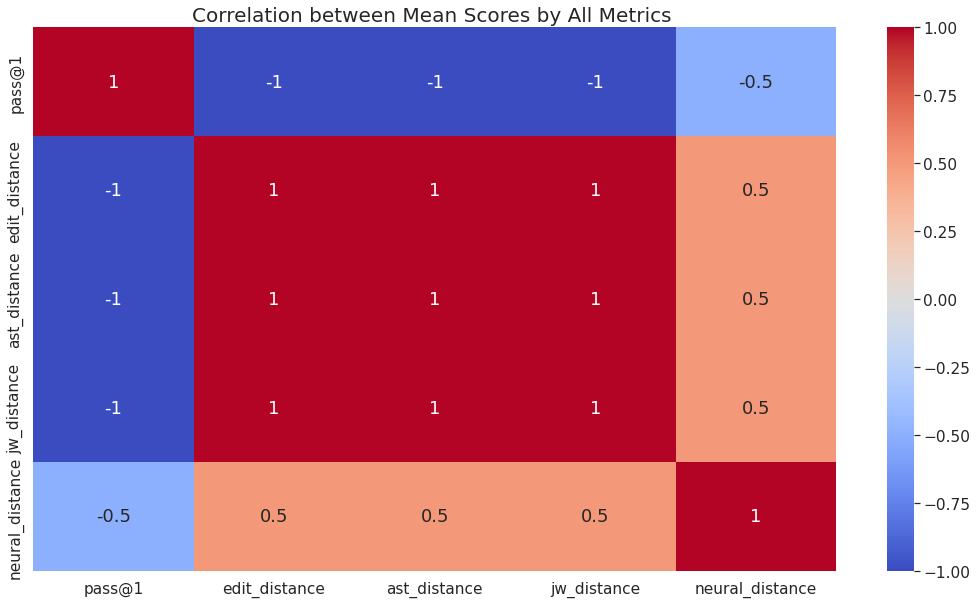

In [6]:
cor_method = "spearman"
rank_df = df[["pass@1", "edit_distance", "ast_distance", "jw_distance", "neural_distance"]]
def plot_cor(df, cor_method = "spearman"): 
    plt.figure(figsize=(18,10))
    sns.set(font_scale=1.4) 
    sns.heatmap(df.corr(method=cor_method), annot = True,cmap= 'coolwarm', annot_kws={"size":18});
    plt.title(f"Correlation between Mean Scores by All Metrics ", fontsize=20);
plot_cor(rank_df)

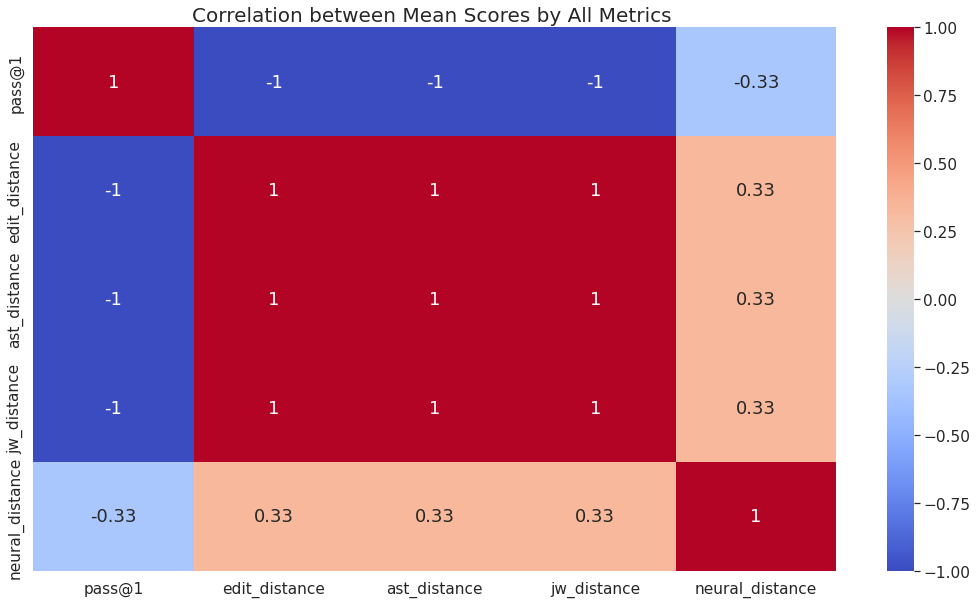

In [7]:
plot_cor(rank_df, cor_method="kendall")